In [1]:
# Usual Libraries
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from glob import glob
from tqdm import tqdm
from pathlib import Path

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [2]:
general_path = "D:/Data"
classes = list(os.listdir(f'{general_path}/genres_original/'))
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


# Explore Audio Data

## Understanding Audio

In [3]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/blues/blues.00000.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [4]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847] 

Audio File shape: (661794,)


## 2D Representation: Sound Waves

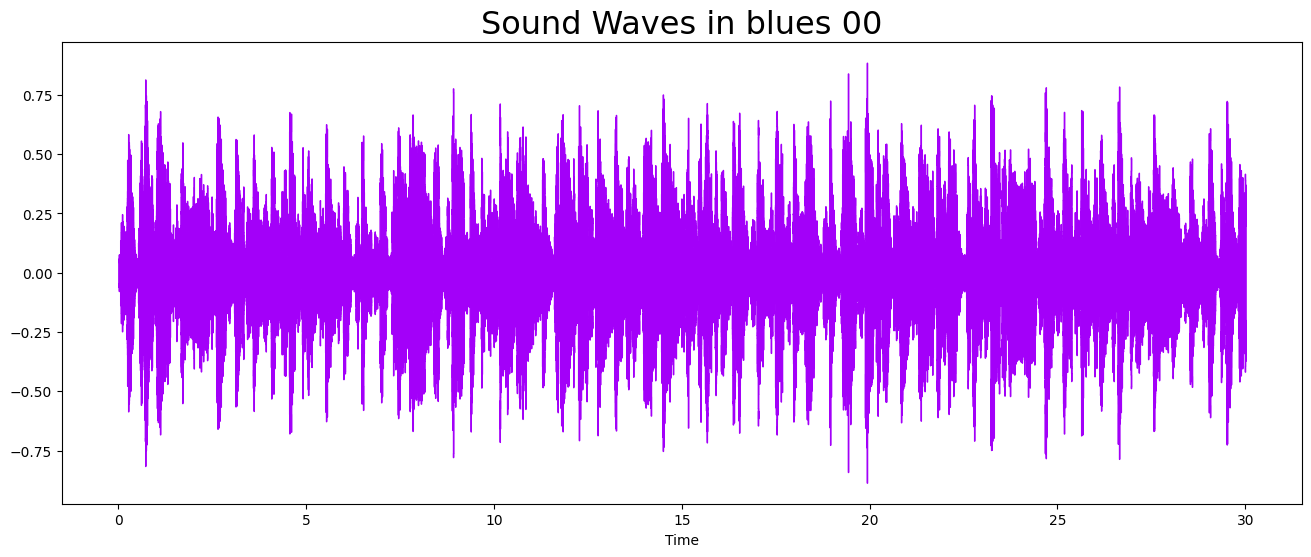

In [5]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = '#A300F9');
plt.title("Sound Waves in blues 00", fontsize = 23);

## Fourier Transform***

In [6]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


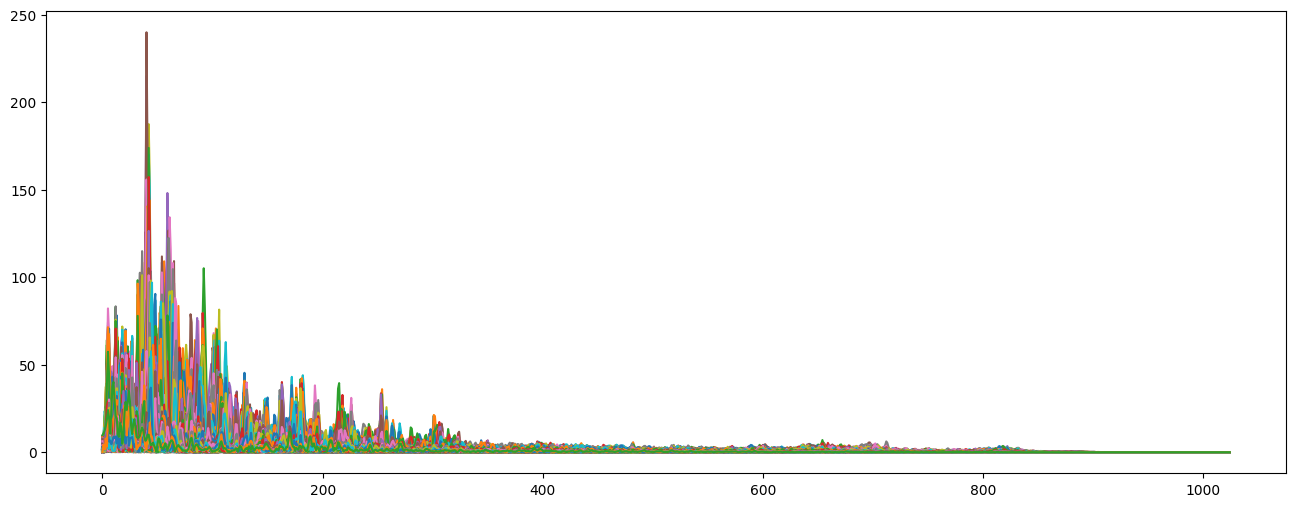

In [7]:
plt.figure(figsize = (16, 6))
plt.plot(D);

## Spectrogram

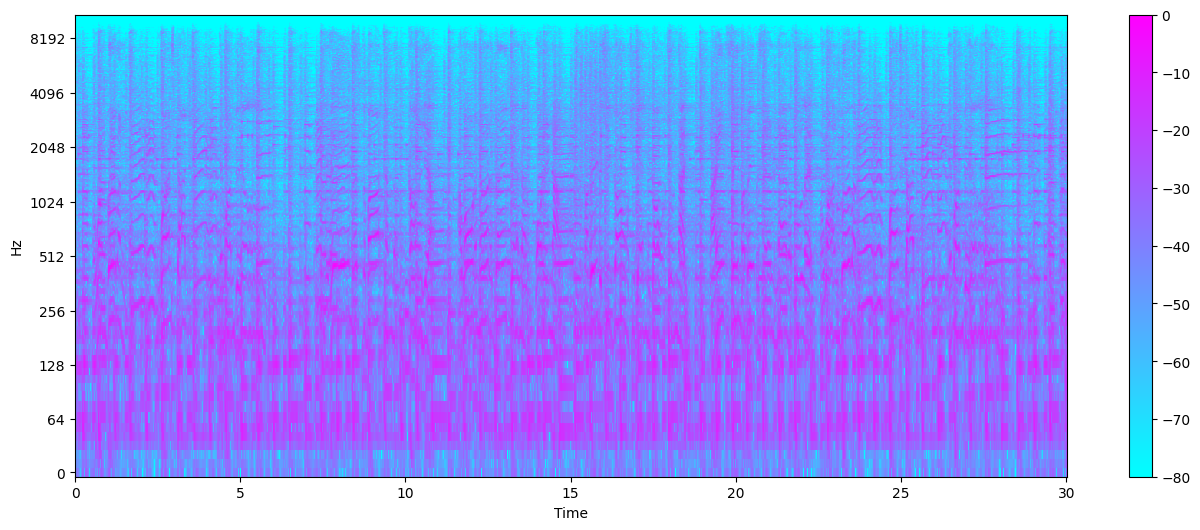

In [8]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool')
plt.colorbar();

## Mel Spectrogram

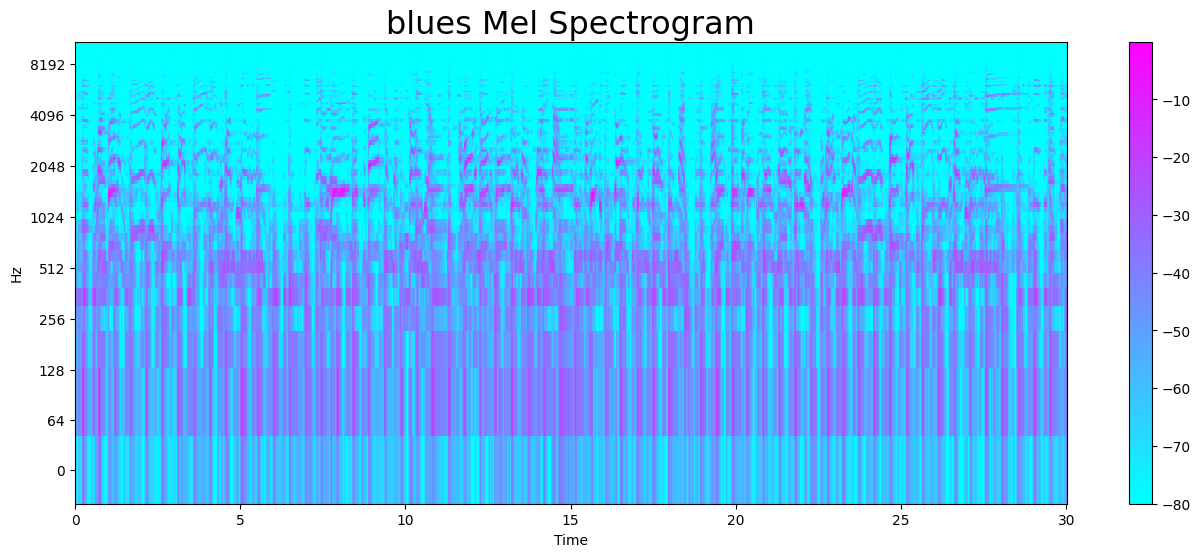

In [9]:
y, sr = librosa.load(f'{general_path}/genres_original/blues/blues.00000.wav')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("blues Mel Spectrogram", fontsize = 23);

## Audio Features

### Zero Crossing Rate***

In [10]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

55031


### Harmonics and Perceptrual

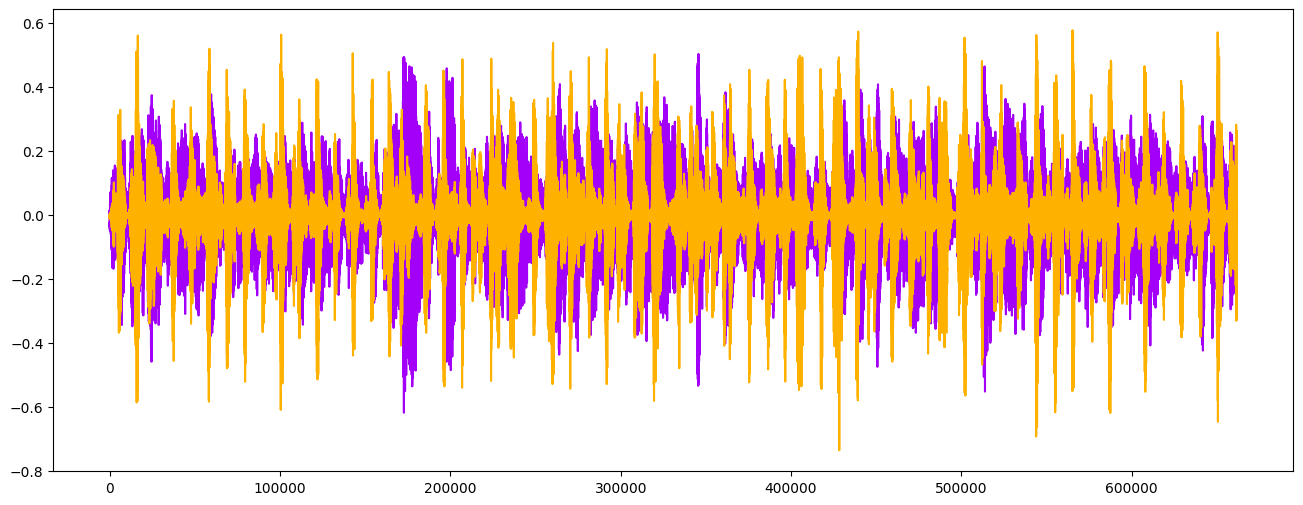

In [11]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

### Tempo BMP (beats per minute)

In [12]:
tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
tempo

123.046875

### Spectral Centroid***

In [13]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [2122.97749428 2102.62106711 1955.28567059 ... 1490.45683883 1507.40420474
 1439.64315882] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


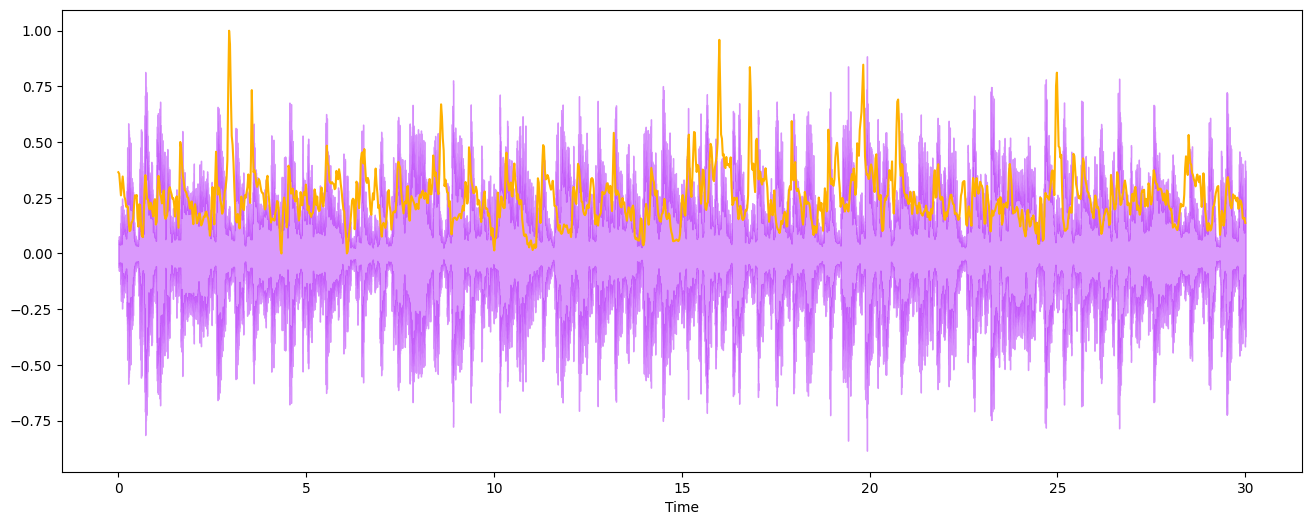

In [14]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

### Spectral Rolloff***

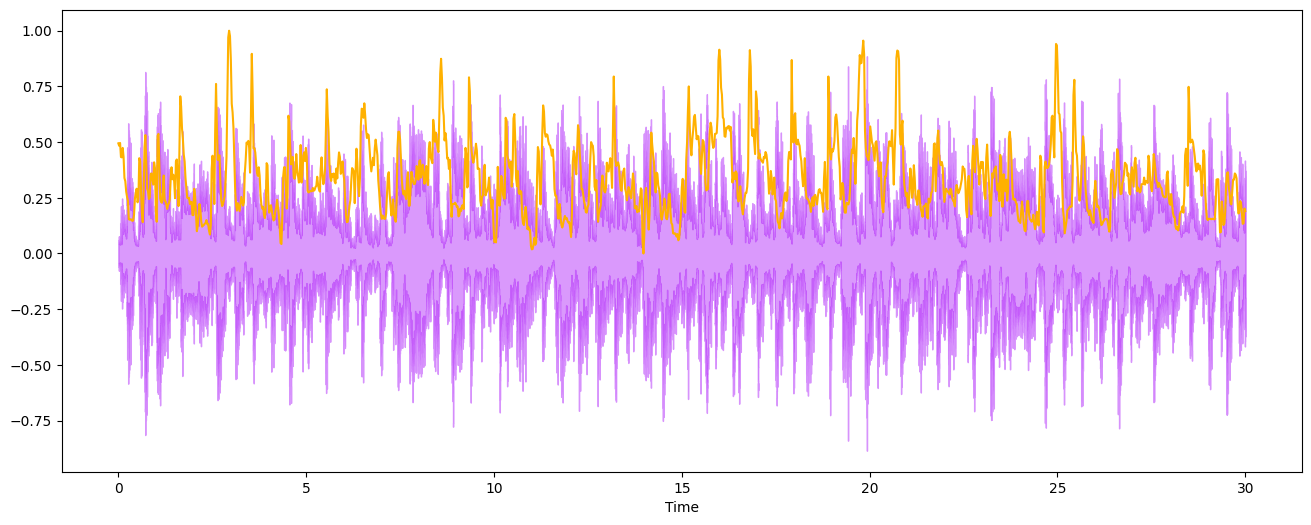

In [15]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

### Mel-Frequency Cepstral Coefficients***

mfccs shape: (20, 1293)


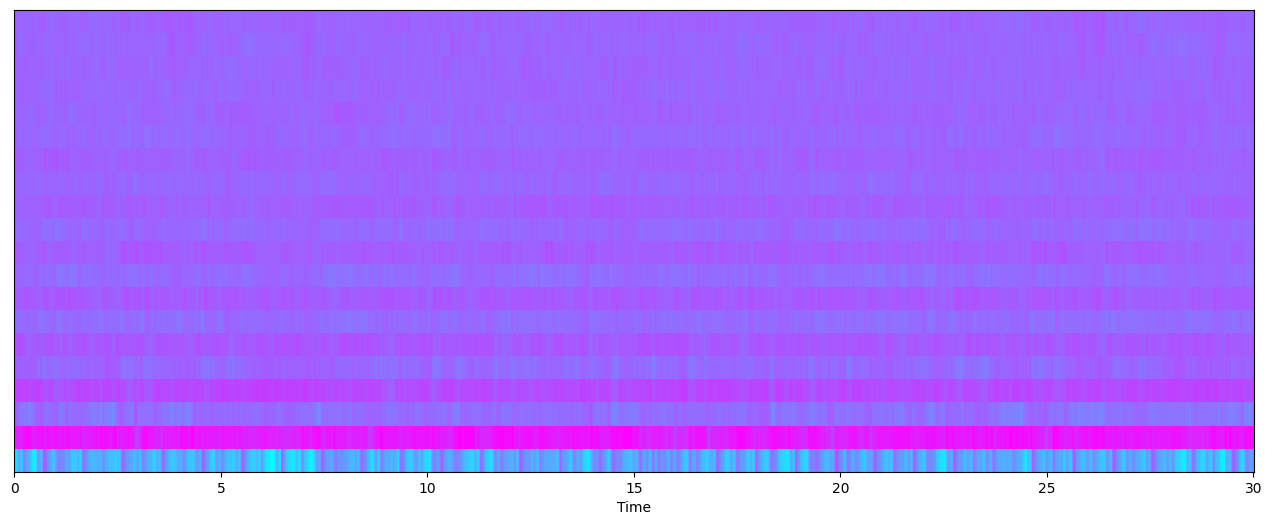

In [16]:
mfccs = librosa.feature.mfcc(y=audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

Mean: 8.1132384e-10 

Var: 1.0


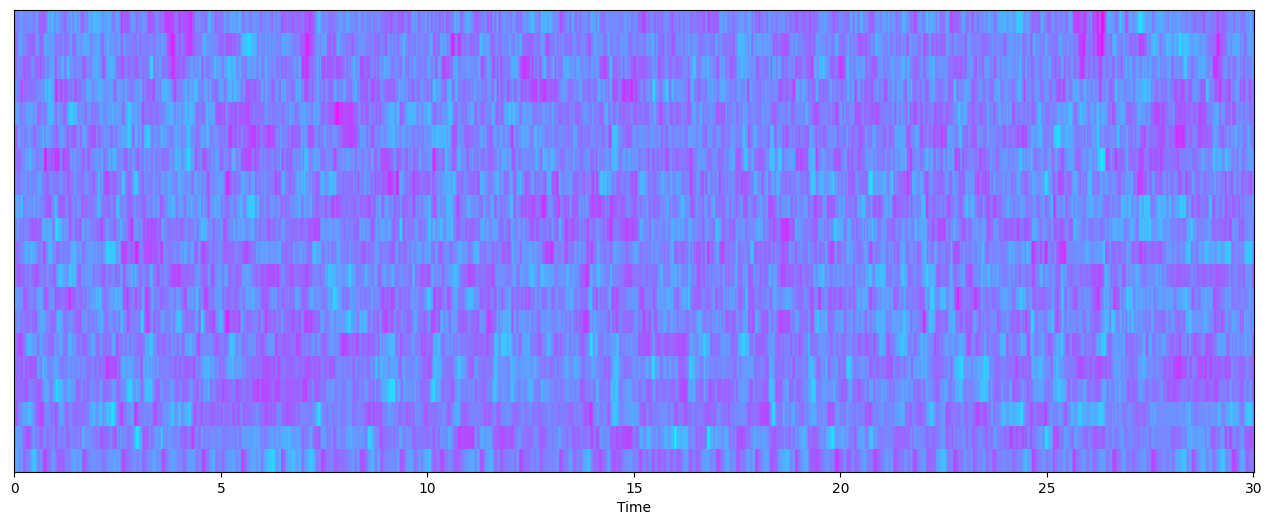

In [17]:
# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

### Chroma Frequencies

Chromogram shape: (12, 133)


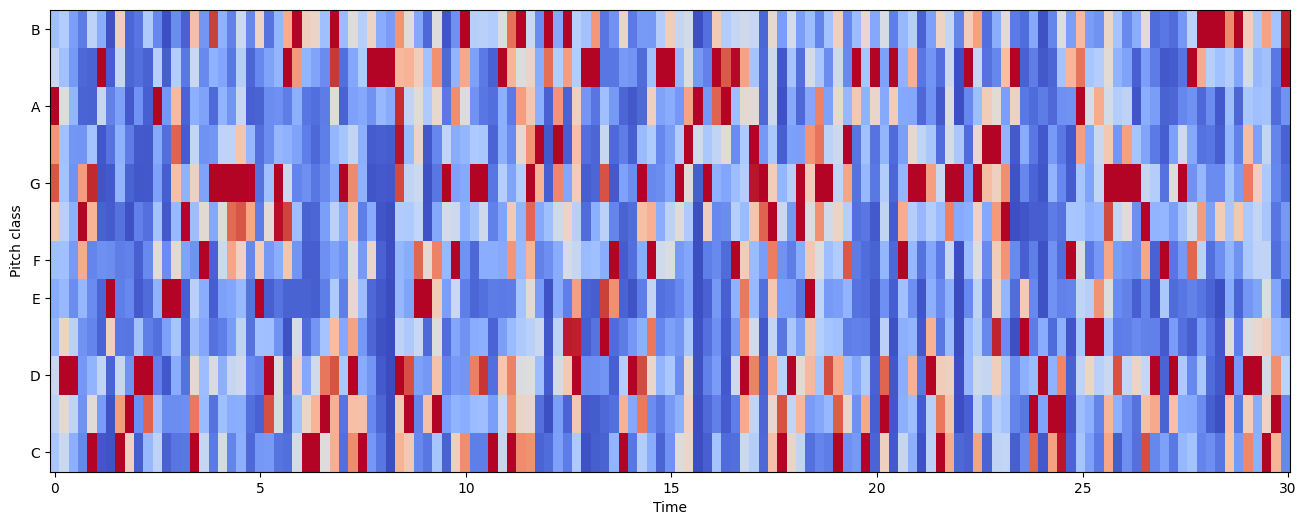

In [18]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

# Feature Extraction

In [19]:
general_path = "D:/Data"
datas = glob(f'{general_path}/genres_original/*/*.wav')
datas = [str(data).replace('\\', '/') for data in datas]

In [20]:
features_df = pd.DataFrame()
frame_length = int(sr * 0.025)
hop_length = frame_length // 2

In [21]:
# for data in tqdm(datas):
#     y, sr = librosa.load(data)  # 加载音频文件
#     # Timbral Texture Features
#     spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
#     spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
#     onset_env = librosa.onset.onset_strength(y=y, sr=sr)
#     spectral_flux = np.diff(onset_env)
#     zero_crossings = librosa.feature.zero_crossing_rate(y)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
#     energy = np.array([sum(abs(y[i:i+frame_length]**2)) for i in range(0, len(y), hop_length)])

#     # Rhythmic Content Features
#     tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

#     # Pitch Content Features
#     pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
#     chroma = librosa.feature.chroma_stft(y=y, sr=sr)

#     # Prepare feature data for DataFrame
#     feature_data = {
#         'Filename': data.split('/')[-1],
#         'Length': len(y),
#         'Spectral Centroids Mean': np.mean(spectral_centroids),
#         'Spectral Centroids Var': np.var(spectral_centroids),
#         'Spectral Rolloff Mean': np.mean(spectral_rolloff),
#         'Spectral Rolloff Var': np.var(spectral_rolloff),
#         'Spectral Flux Mean': np.mean(spectral_flux),
#         'Spectral Flux Var': np.var(spectral_flux),
#         'Zero Crossings Mean': np.mean(zero_crossings),
#         'Zero Crossings Var': np.var(zero_crossings),
#         'Energy Mean': np.mean(energy),
#         'Energy Var': np.var(energy),
#         'Tempo': tempo,
#         'Beats Mean': np.mean(beats),
#         'Beats Var': np.var(beats),
#         'Pitches Mean': np.mean(pitches),
#         'Pitches Var': np.var(pitches),
#         'Magnitudes Mean': np.mean(magnitudes),
#         'Magnitudes Var': np.var(magnitudes)
#     }

#     # MFCC
#     for i, (mean, var) in enumerate(zip(np.mean(mfccs, axis=1), np.var(mfccs, axis=1)), 1):
#         feature_data[f'MFCC{i}_Mean'] = mean
#         feature_data[f'MFCC{i}_Var'] = var
#     # Chroma
#     for i, (mean, var) in enumerate(zip(np.mean(chroma, axis=1), np.var(chroma, axis=1)), 1):
#         feature_data[f'Chroma{i}_Mean'] = mean
#         feature_data[f'Chroma{i}_Var'] = var

#     feature_data['label'] = data.split('/')[-2]
#     feature_frame = pd.DataFrame([feature_data])
#     features_df = pd.concat([features_df, feature_frame], ignore_index=True)

    

In [22]:
# features_df.to_csv("features.csv", index=False)

# Machine Learning Classification

In [23]:
# Reading in the Data
data = pd.read_csv("features.csv")
data = data.iloc[0:, 1:] 

In [24]:
data

,Length,Spectral Centroids Mean,Spectral Centroids Var,Spectral Rolloff Mean,Spectral Rolloff Var,Spectral Flux Mean,Spectral Flux Var,Zero Crossings Mean,Zero Crossings Var,Energy Mean,...,Chroma8_Var,Chroma9_Mean,Chroma9_Var,Chroma10_Mean,Chroma10_Var,Chroma11_Mean,Chroma11_Var,Chroma12_Mean,Chroma12_Var,label
0,661794,1784.122641,129745.484419,3805.723030,9.012529e+05,0.000506,2.091888,0.083045,0.000767,10.904924,...,0.119802,0.295986,0.064384,0.315080,0.078741,0.407008,0.110865,0.385101,0.085667,blues
1,661794,1530.261767,375915.508778,3550.713616,2.978311e+06,0.000602,3.548260,0.056040,0.001448,6.380190,...,0.134552,0.384179,0.087199,0.255326,0.054376,0.284776,0.077856,0.334094,0.072455,blues
2,661794,1552.832481,156471.010904,3042.410115,7.841309e+05,0.000528,4.120218,0.076291,0.001007,18.491970,...,0.063201,0.334152,0.061145,0.401819,0.110965,0.384389,0.063252,0.588508,0.124609,blues
3,661794,1070.153418,184366.009438,2184.879029,1.493078e+06,0.000599,2.507256,0.033309,0.000423,14.460701,...,0.039754,0.246271,0.046257,0.315111,0.086286,0.316579,0.078955,0.383199,0.113743,blues
4,661794,1835.128513,343249.495746,3579.957471,1.572336e+06,0.000212,4.580002,0.101461,0.001954,5.884487,...,0.031364,0.276424,0.092058,0.324327,0.054561,0.555124,0.126620,0.272931,0.047707,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,661794,2008.174521,282095.548027,4253.623647,1.222211e+06,0.000534,1.495590,0.089227,0.001305,3.670796,...,0.098524,0.294250,0.034349,0.434778,0.088078,0.232959,0.027985,0.193236,0.045250,rock
996,661794,2006.827265,182135.837546,4149.171791,1.046246e+06,0.001225,0.798559,0.097664,0.000868,3.544918,...,0.022634,0.562999,0.064626,0.703196,0.100375,0.363564,0.042107,0.322926,0.055644,rock
997,661794,2077.565822,231716.291148,4031.530224,8.044889e+05,0.000561,0.775458,0.121823,0.001697,3.850285,...,0.092484,0.355976,0.041672,0.527072,0.105480,0.386605,0.044101,0.468874,0.091413,rock
998,661794,1398.649504,240406.206978,3015.597697,1.332918e+06,0.000249,1.203915,0.048724,0.000808,4.536359,...,0.135283,0.424676,0.076434,0.336892,0.105117,0.263770,0.058463,0.341094,0.065122,rock


In [25]:
# Prepare features and target
y = data['label']
X = data.drop('label', axis=1)

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# 5-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 使用交叉验证计算精确度
    accuracies = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

    # 打印每一折的结果及平均精确度
    print(f"{title:=^100}")
    print(f"{title}: Accuracy per fold: {accuracies}")
    print(f"{title}: Average Accuracy: {round(accuracies.mean(), 5)}")
    print(f"{title}: Total Accuracy: {round(accuracy_score(y_test, preds), 5)}")

    # Comfusion_Matrix
    CM = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(CM, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # adding labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # adding levels
    thresh = CM.max() / 2.
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            plt.text(j, i, format(CM[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if CM[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'{title} Confusion Matrix')
    plt.show()

============================================Naive Bayes=============================================
Naive Bayes: Accuracy per fold: [0.58  0.57  0.575 0.65  0.6  ]
Naive Bayes: Average Accuracy: 0.595
Naive Bayes: Total Accuracy: 0.54667


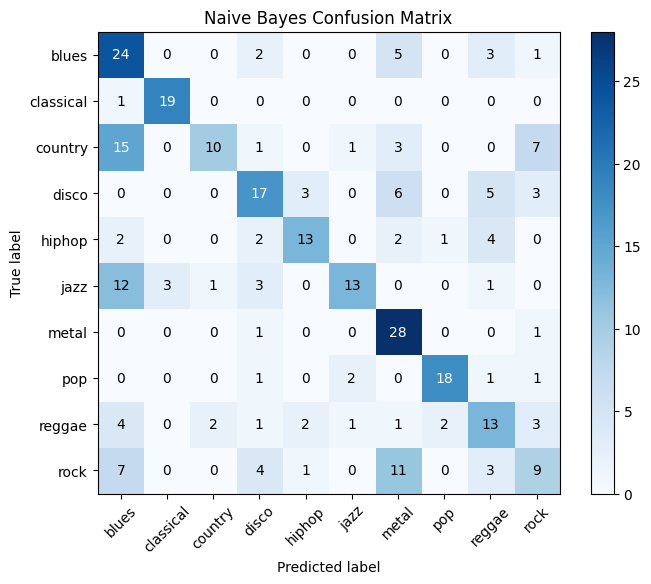

====================================Stochastic Gradient Descent=====================================
Stochastic Gradient Descent: Accuracy per fold: [0.535 0.615 0.575 0.685 0.605]
Stochastic Gradient Descent: Average Accuracy: 0.603
Stochastic Gradient Descent: Total Accuracy: 0.62667


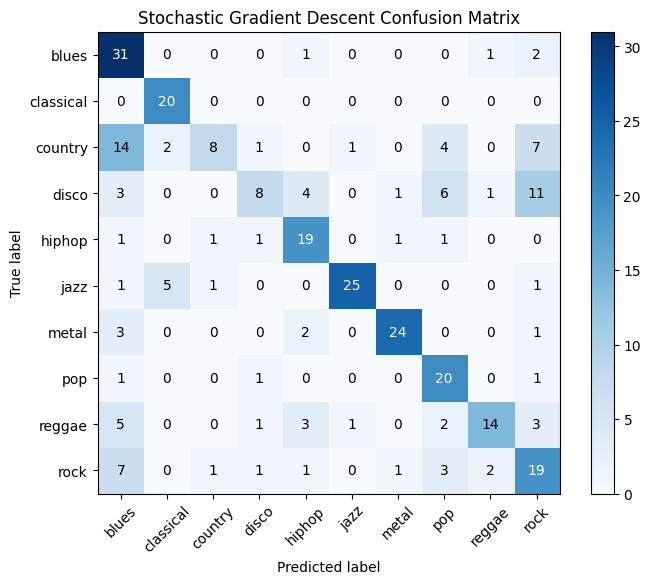

================================================KNN=================================================
KNN: Accuracy per fold: [0.615 0.6   0.645 0.65  0.59 ]
KNN: Average Accuracy: 0.62
KNN: Total Accuracy: 0.54333


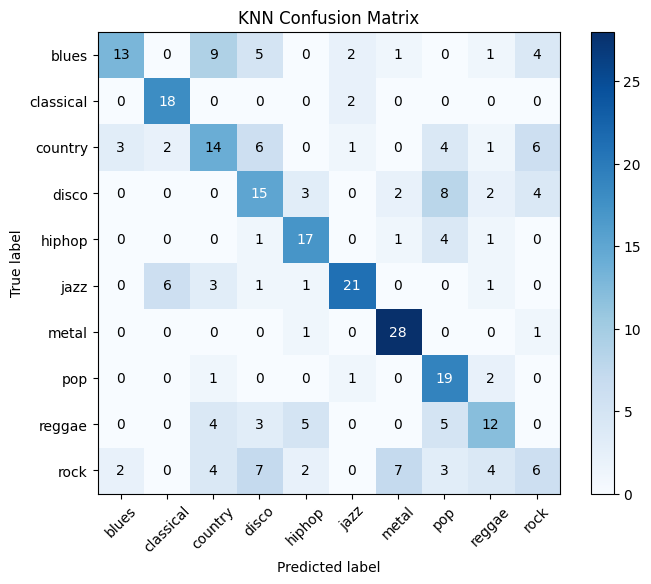

==========================================Decission trees===========================================
Decission trees: Accuracy per fold: [0.545 0.58  0.62  0.61  0.56 ]
Decission trees: Average Accuracy: 0.583
Decission trees: Total Accuracy: 0.59


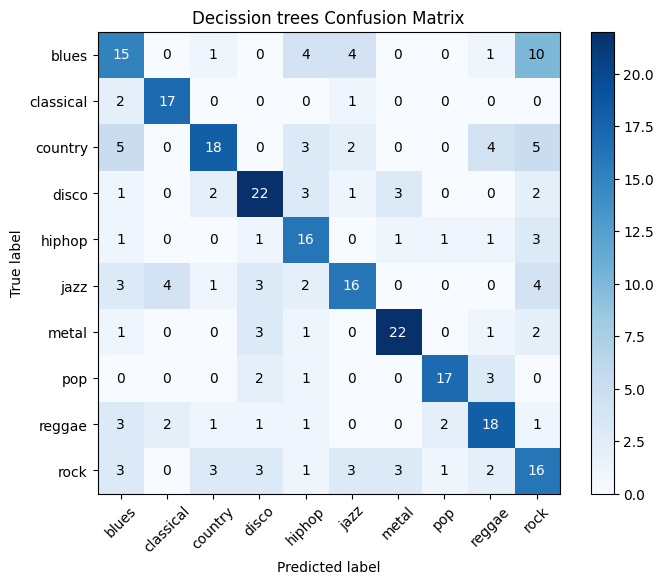

===========================================Random Forest============================================
Random Forest: Accuracy per fold: [0.755 0.78  0.81  0.815 0.78 ]
Random Forest: Average Accuracy: 0.788
Random Forest: Total Accuracy: 0.72


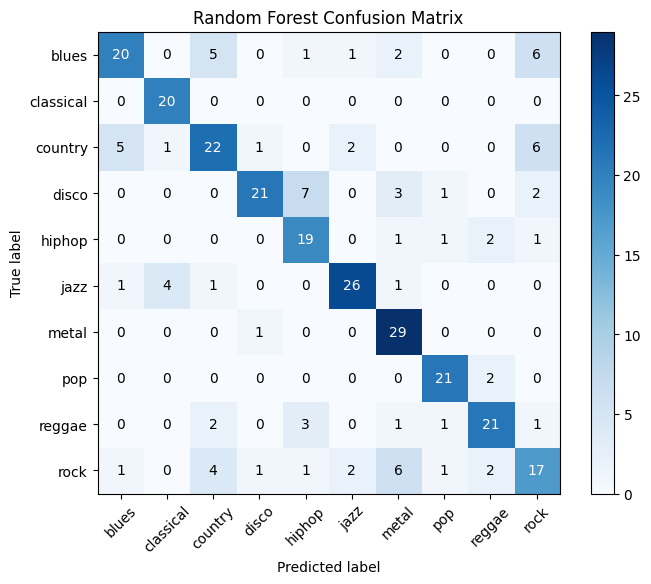

=======================================Support Vector Machine=======================================
Support Vector Machine: Accuracy per fold: [0.675 0.645 0.695 0.73  0.735]
Support Vector Machine: Average Accuracy: 0.696
Support Vector Machine: Total Accuracy: 0.62667


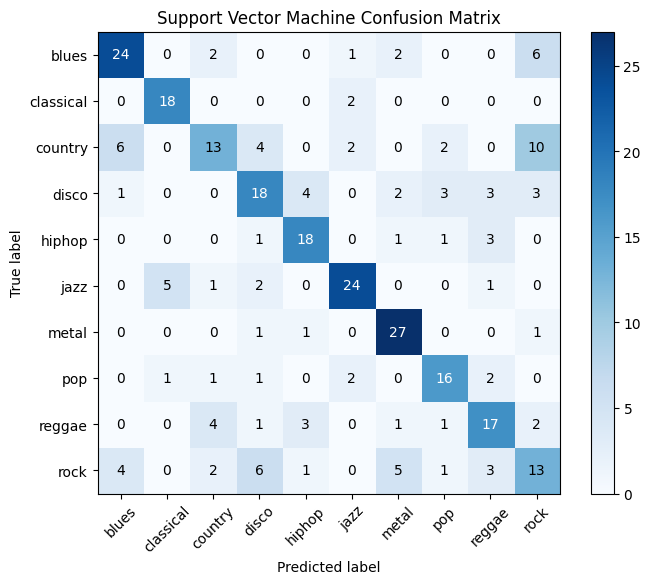

========================================Logistic Regression=========================================
Logistic Regression: Accuracy per fold: [0.685 0.695 0.64  0.735 0.71 ]
Logistic Regression: Average Accuracy: 0.693
Logistic Regression: Total Accuracy: 0.63667


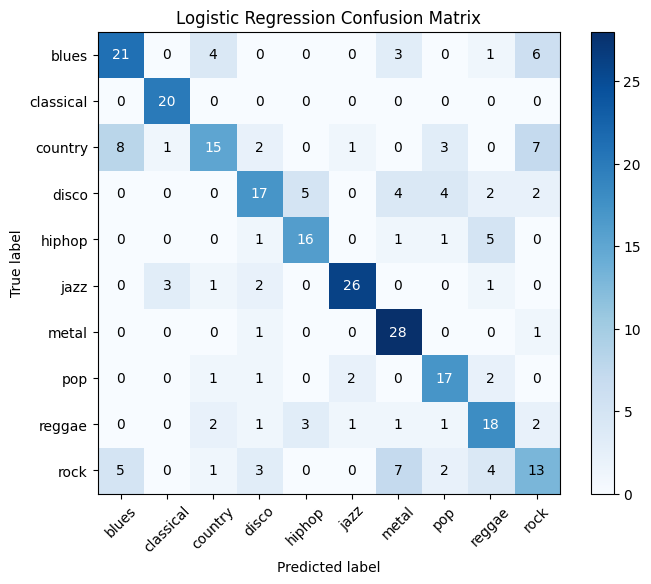

============================================Neural Nets=============================================
Neural Nets: Accuracy per fold: [0.71  0.63  0.63  0.695 0.66 ]
Neural Nets: Average Accuracy: 0.665
Neural Nets: Total Accuracy: 0.65667


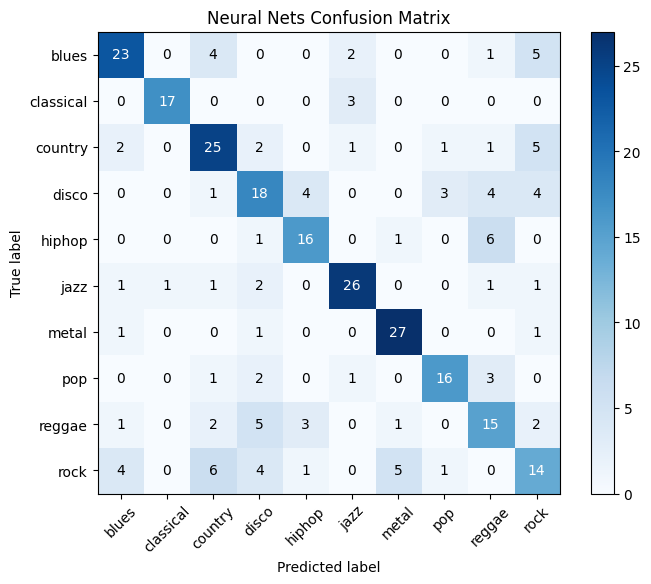

=======================================Cross Gradient Booster=======================================
Cross Gradient Booster: Accuracy per fold: [0.795 0.78  0.785 0.775 0.755]
Cross Gradient Booster: Average Accuracy: 0.778
Cross Gradient Booster: Total Accuracy: 0.70333


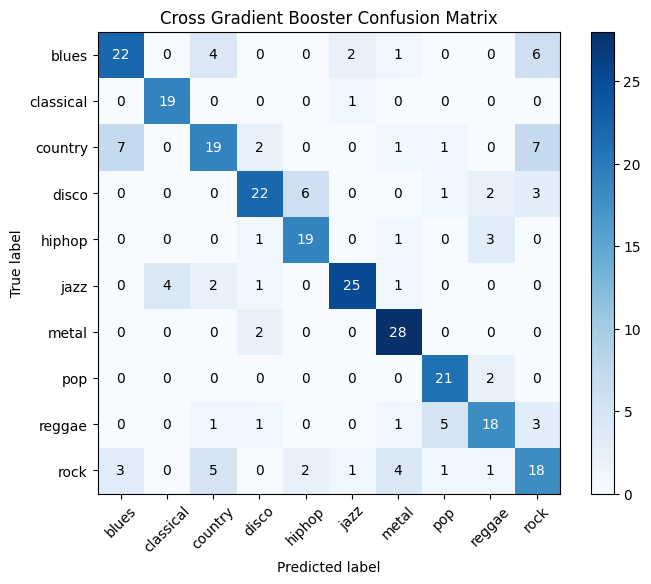

===============================Cross Gradient Booster (Random Forest)===============================
Cross Gradient Booster (Random Forest): Accuracy per fold: [0.685 0.695 0.715 0.715 0.69 ]
Cross Gradient Booster (Random Forest): Average Accuracy: 0.7
Cross Gradient Booster (Random Forest): Total Accuracy: 0.66667


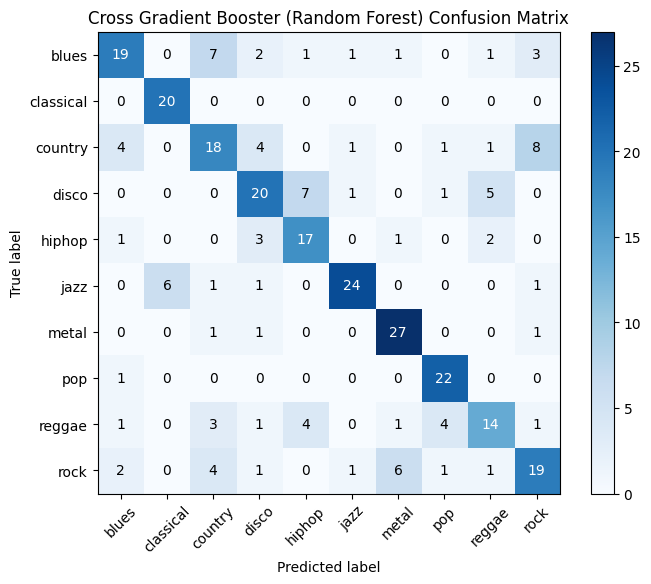

In [28]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")